In [2]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

pd.set_option('display.max_rows', 60)
pd.set_option('display.min_rows', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 40)

%load_ext autoreload
%autoreload 2

%matplotlib inline


In [3]:
from ndgsp import GSR, RNC, ProductGraph, MultivariateFilterFunction
from ndgsp.lin_system import solve_SPCGM

from pykronecker import KroneckerDiag, KroneckerIdentity

from scipy.optimize import minimize
from sklearn.cluster import KMeans
import subprocess

import json

from tqdm.auto import tqdm
import time
from itertools import product

Using Jax backend with device gpu:0


In [4]:
def get_data(Ns, seed: int=0):

    np.random.seed(seed)
    N = np.prod(Ns)
    Y = np.random.normal(size=Ns)
    S = np.random.randint(2, size=Ns)
    Y[~S.astype(bool)] = np.nan

    return Y, S


def get_graph(Ns):

    graph = ProductGraph.random_connected(*Ns)
    ffunc = MultivariateFilterFunction.diffusion(beta=[0.5, 0.7, 0.6])
    ffunc_ = MultivariateFilterFunction.diffusion(beta=[0.5, 0.7, 0.6])
    G = ffunc(graph.lams)

    return graph, ffunc, ffunc_, G


def compute_omega_element(n, graph, G, S):

    sig = np.zeros_like(G)
    sig[n] = 1

    DG = KroneckerDiag(G)
    DS = KroneckerDiag(S)

    A_precon = DG @ graph.U.T @ DS @ graph.U @ DG + KroneckerIdentity(like=DG)
    var, nits = solve_SPCGM(A_precon=A_precon, Y=sig, Phi=graph.U @ DG)

    return np.log(var[n])


def compute_Omega(graph, G, S):
    Ns = G.shape
    return np.array([compute_omega_element((n1, n2, n3), graph, G, S) for n1, n2, n3 in tqdm(list(product(*[range(N) for N in Ns])), leave=False)]).reshape(Ns)



def get_X(graph, S, G, ffunc):

    X1 = np.ones_like(G)
    X2 = (1 - S)
    X3 = graph.filter(X2, ffunc)
    X4 = (graph.U * graph.U) @ G
    X5 = (graph.U * graph.U) @ (G ** 2)
    X6 = graph.A @ np.ones_like(G)
    X7 = graph.filter(X6, ffunc)

    X = np.array([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel(), X6.ravel(), X7.ravel()]).T

    # cluster the features
    X_ = X.copy()
    X_[:, 1:] = X_[:, 1:] / X_[:, 1:].std(axis=0)
    X_[:, 1:] = X_[:, 1:] - X_[:, 1:].mean(axis=0)

    n_clusters = 10
    clusters = KMeans(n_clusters=n_clusters).fit_predict(X_)

    return X, clusters



def get_Omega_Q_active(Omega, Q: int, clusters):
    """
    Get Omega_Q tensor with Q non-missing values picked by cycling 
    though feature clusters. The rest nan.
    """

    n_clusters = clusters.max() + 1

    groups = [np.argwhere(clusters == i).reshape(-1).tolist() for i in range(n_clusters)]

    np.random.shuffle(groups)

    for group in groups:
        np.random.shuffle(group)

    j = 0

    nqs = np.zeros(Q, dtype=int)

    for i in range(Q):

        group = groups[j % n_clusters]

        while len(group) == 0:
            j += 1
            group = groups[j % n_clusters]

        nqs[i] = group.pop()
        j += 1


    S = np.zeros(np.prod(Omega.shape), dtype=bool)

    S[nqs] = True

    S = S.reshape(*Omega.shape)

    Omega_Q = np.zeros_like(Omega)
    Omega_Q[:] = np.nan
    Omega_Q[S] = Omega[S]

    return Omega_Q


In [13]:
class RidgeRegression:

    def __init__(self, Omega_Q, X, lam=1) -> None:
        
        self.Q = (~np.isnan(Omega_Q)).astype(float)
        self.DQ = KroneckerDiag(self.Q)
        self.Omega_Q = np.nan_to_num(Omega_Q, nan=0, copy=True)
        self.X = X
        self.lam = lam

    def solve(self):

        self.beta = np.linalg.solve(self.X.T @ self.DQ @ self.X + self.lam * np.eye(self.X.shape[1]), self.X.T @ self.Omega_Q.ravel())

        pred = (self.X @ self.beta).reshape(self.Omega_Q.shape)
        pred[self.Q.astype(bool)] = self.Omega_Q[self.Q.astype(bool)]

        return pred


class LFP:

    def __init__(self, Omega_Q, X, graph, ffunc, lam) -> None:

        mod = RidgeRegression(Omega_Q, X, lam=lam)
        mod.solve()
        self.w0 = np.array(mod.beta.tolist() + np.log(ffunc.beta.tolist() * 2).tolist())
        
        self.Q = (~np.isnan(Omega_Q)).astype(float)
        self.Omega_Q = np.nan_to_num(Omega_Q, nan=0, copy=True)
        self.X = X.copy()
        self.lam = lam
        self.graph = graph
        self.ffunc = ffunc

        self.beta_len = len(ffunc.beta)

    def predict(self, w):
        
        if self.beta_len == 1:
            beta1, beta2 = np.exp(w[7:])

        else:
            beta1 = np.exp(w[7:7+self.beta_len])
            beta2 = np.exp(w[7+self.beta_len:])
        
        self.ffunc.set_beta(beta1)

        self.X[:, 2] = self.graph.filter(self.X[:, 1], self.ffunc)

        self.ffunc.set_beta(beta2)

        self.X[:, 6] = self.graph.filter(self.X[:, 5], self.ffunc)
        
        return (self.X @ w[:7]).reshape(self.Omega_Q.shape)
    

    def loss(self, w):

        pred = self.predict(w)

        l =  float(((self.Omega_Q - self.Q * pred) ** 2).sum() + self.lam * ((w - self.w0) ** 2).sum())

        print(f'params: {w}, loss: {l:.4e}', end='\r')

        return l
    

    def solve(self):

        sol = minimize(self.loss, x0=self.w0, method='Nelder-Mead', options={'maxiter': 10000})

        pred = np.array(self.predict(sol.x))

        pred[self.Q.astype(bool)] = self.Omega_Q[self.Q.astype(bool)]

        return pred
    


class GSRVar:

    def __init__(self, Omega_Q, graph, ffunc, gamma) -> None:
        
        self.gsr = GSR(Omega_Q, graph, ffunc, gamma=gamma)
        self.Omega_Q = np.nan_to_num(Omega_Q, nan=0, copy=True)
        self.Q = (~np.isnan(Omega_Q)).astype(float)

    def solve(self):

        pred = np.array(self.gsr.solve())

        pred[self.Q.astype(bool)] = self.Omega_Q[self.Q.astype(bool)]

        return pred
    

class RNCVar:

    def __init__(self, X, Omega_Q, graph, ffunc, gamma=1e-1, lam=1e-5) -> None:

        self.rnc = RNC(X.reshape(*Omega_Q.shape, -1), Omega_Q, graph, ffunc, gamma=gamma, lam=lam)
        self.Omega_Q = np.nan_to_num(Omega_Q, nan=0, copy=True)
        self.Q = (~np.isnan(Omega_Q)).astype(float)

    def solve(self):

        pred = np.array(self.rnc.solve())
        pred[self.Q.astype(bool)] = self.Omega_Q[self.Q.astype(bool)]

        return pred
    

class Bekas:

    def __init__(self, graph, G, S, N_solves) -> None:
        
        self.graph = graph
        self.G = G
        self.S = S
        self.N_solves = N_solves


    def solve(self):

        N = int(np.prod(self.G.shape))

        V = 2 * np.random.randint(2, size=(N, self.N_solves)) - 1

        DS = KroneckerDiag(self.S)
        DG = KroneckerDiag(self.G)

        A_precon = DG @ self.graph.U.T @ DS @ self.graph.U @ DG + KroneckerIdentity(like=DG)

        MVs = np.zeros((N, self.N_solves))

        for i in range(self.N_solves):

            MV, nits = solve_SPCGM(A_precon=A_precon, Y=V[:, i], Phi=self.graph.U @ DG)
            MVs[:, i] = MV

        pred = np.sum(MVs * V, axis=1) / np.sum(V ** 2, axis=1)

        return pred.reshape(self.G.shape)
    

class Sample:

    def __init__(self, Y, graph, ffunc, n_samples) -> None:
        
        
        self.Y = Y
        self.graph = graph
        self.ffunc = ffunc
        self.n_samples = n_samples

    def solve(self):
        
        return np.array(GSR(self.Y, self.graph, self.ffunc, 1).sample(self.n_samples)).var(0)


In [6]:

def square_error(true, pred: np.ndarray):
    return ((true - pred) ** 2).sum() 


def r_squared(true, pred: np.ndarray):
    return 1 - square_error(true, pred) / ((true - true.mean()) ** 2).sum() 

In [ ]:
# TAKES A LONG TIME TO RUN

n_samples = 50

for k in range(2, 6):

    square_errors = {'RR':[],
                'Bekas':[],
                'RNC':[],
                'LFP':[],
                'Sample':[]}

    r_squareds = {'RR':[],
                'Bekas':[],
                'RNC':[],
                'LFP':[],
                'Sample':[]}

    for n in tqdm(range(5, 30)):

        Y, S = get_data((n, n, n), seed=int(time.time()))

        graph, ffunc, ffunc_, G = get_graph((n, n, n))
        Omega = compute_Omega(graph, G, S)
        var = np.exp(Omega)

        X, clusters = get_X(graph, S, G, ffunc)

        Omega_Q = get_Omega_Q_active(Omega, n_samples, clusters)

        mods = {'RR': RidgeRegression(Omega_Q, X, lam=1e-5),
                'RNC': RNCVar(X, Omega_Q, graph, ffunc, gamma=1e-1, lam=1e-5),
                'LFP': LFP(Omega_Q, X, graph, ffunc_, lam=1e-5), 
                'Bekas': Bekas(graph, G, S, n_samples), 
                'Sample': Sample(Y, graph, ffunc, n_samples)}
        
        preds = {'RR': np.exp(mods['RR'].solve()),
                'RNC': np.exp(mods['RNC'].solve()),
                'LFP': np.exp(mods['LFP'].solve()),
                'Bekas': mods['Bekas'].solve(),
                'Sample': mods['Sample'].solve()}

        
        for mod, pred in preds.items():

            square_errors[mod].append(square_error(np.exp(Omega), pred))
            r_squareds[mod].append(r_squared(np.exp(Omega), pred))


    with open(f'r_squared_{k}.json', 'w') as f:
        f.write(json.dumps({key: np.array(item).tolist() for key, item in r_squareds.items()}))

    with open(f'square_error_{k}.json', 'w') as f:
        f.write(json.dumps({key: np.array(item).tolist() for key, item in square_errors.items()}))



In [5]:
rs = []
se = []

for k in range(1, 6):

    with open(f'r_squared_{k}.json', 'r') as f:
        rs.append(json.load(f))

    with open(f'square_error_{k}.json', 'r') as f:
        se.append(json.load(f))


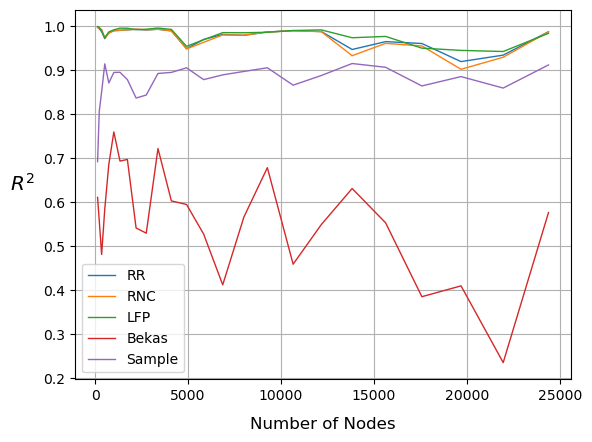

In [6]:
plt.figure()


for mod in ['RR', 'RNC', 'LFP', 'Bekas', 'Sample']:

    plt.plot(np.array(range(5, 30)) ** 3, rs[0][mod], label=mod, lw=1)

plt.legend()



plt.grid()

plt.ylabel('$R^2$', rotation=0, labelpad=15, fontsize='x-large')

plt.xlabel('Number of Nodes', labelpad=10, fontsize='large')



plt.savefig('sample_diag_estimation.pdf')

In [8]:
def range_gen(N):

    n = 0

    while n < N:

        yield n

        n += 1

def range_gen_(N):

    return range_gen(N + 1)


for i in range_gen_(5):

    print(i)

0
1
2
3
4
5
